In [1]:
import pandas as pd
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp
import numpy as np
from hyperopt import Trials, tpe, fmin
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier

In [2]:
ma = pd.read_csv("../16 Mycoplosma/ma.csv")
map = pd.read_csv("../16 Mycoplosma/map.csv")
marth = pd.read_csv("../16 Mycoplosma/marth.csv")
mcap = pd.read_csv("../16 Mycoplosma/mcap.csv")
mcon = pd.read_csv("../16 Mycoplosma/mcon.csv")
mcro = pd.read_csv("../16 Mycoplosma/mcro.csv")
mgal = pd.read_csv("../16 Mycoplosma/mgal.csv")
mhom = pd.read_csv("../16 Mycoplosma/mhom.csv")
mhyoJ = pd.read_csv("../16 Mycoplosma/mhyoJ.csv")
mhyo232 = pd.read_csv("../16 Mycoplosma/mhyo232.csv")
mhyo7448 = pd.read_csv("../16 Mycoplosma/mhyo7448.csv")
mm163K = pd.read_csv("../16 Mycoplosma/mm163K.csv")
mms = pd.read_csv("../16 Mycoplosma/mms.csv")
mpHF = pd.read_csv("../16 Mycoplosma/mpHF.csv")
mpM = pd.read_csv("../16 Mycoplosma/mpM.csv")
ms53 = pd.read_csv("../16 Mycoplosma/ms53.csv")

In [3]:
def generate_train_test_dataset(index):
    dataset_names = [ma, map, marth, mcap, mcon, mcro, mgal, mhom, mhyoJ, mhyo232, mhyo7448, mm163K, mms, mpHF, mpM, ms53]
    merged_train = dataset_names[:index]+dataset_names[index+1:]
    train_data = pd.concat(merged_train)
    test_data = dataset_names[index]
    return train_data,test_data

In [4]:
train_data , test_data = generate_train_test_dataset(0)

In [5]:
def handle_dataset(dataset):
    columns_to_drop = ['identity','name', 'Amino acid', 'protein_sequence', 'essentiality']
    Xs = dataset.drop(columns = columns_to_drop)
    y = dataset['essentiality']
    return Xs,y

In [6]:
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)

In [7]:
from sklearn.naive_bayes import GaussianNB

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
def nb_bca_cv(params):
    scorer = make_scorer(balanced_accuracy_score)
    model = GaussianNB(var_smoothing=params['var_smoothing'])
    score = -cross_val_score(model, X_resampled, y_resampled, cv=5,scoring=scorer, ).mean()
    return score

In [8]:
space = {
    'var_smoothing': hp.loguniform('var_smoothing', -9, 0) 
}

In [9]:

trials = Trials()

best=fmin(fn=nb_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )


100%|██████████| 100/100 [00:02<00:00, 37.97trial/s, best loss: -0.3671809256661992]


In [11]:
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#feature selection
#RFE
score = []
scorer = make_scorer(balanced_accuracy_score)
model = GaussianNB(**best)
for i in range(26,5,-1):
	X_mutual = SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(X_resampled, y_resampled)
	once = cross_val_score(model, X_mutual, y_resampled, cv=10,scoring=scorer)
	score.append(once.mean())


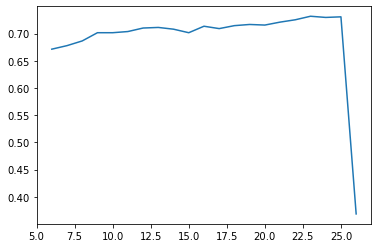

In [12]:
plt.plot(range(26,5,-1), score)
plt.show()    

In [14]:
X_mutual = SelectKBest(score_func=mutual_info_classif, k=25).fit_transform(X_resampled, y_resampled)

In [15]:
Wrapper_score = cross_val_score(model,X_mutual,y_resampled,cv=5,scoring=scorer).mean()
print(Wrapper_score)

0.7308321645628799


In [16]:
def feature_selection(Xs,y):
    Xs_result = SelectKBest(mutual_info_classif, k=25).fit_transform(Xs,y)
    return Xs_result

In [18]:
models= []
score = 0
scores = []

for i in range(0,16):
    if i == 3 :
        scores.append(0.5127968346578312)
        continue
    if i ==12:
        scores.append(0.5123582987129056)
        continue
    train_data, test_data = generate_train_test_dataset(i)
    Xs_train,y_train = handle_dataset(train_data)
    Xs_test,y_test = handle_dataset(test_data)
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
    X_resampled = feature_selection(X_resampled,y_resampled)
    trials = Trials()
    best=fmin(fn=nb_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
    )
    model = GaussianNB(**best)
    models.append(model)
    model.fit(X_resampled,y_resampled)
    Xs_test_fs = feature_selection(Xs_test,y_test)
    tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test_fs))
    scores.append(tpe_test_score)
    print(tpe_test_score)
    if score < tpe_test_score:
        score = tpe_test_score
        best_model = model

100%|██████████| 50/50 [00:00<00:00, 61.03trial/s, best loss: -0.3671809256661992]
0.45332842053549494
100%|██████████| 50/50 [00:00<00:00, 62.70trial/s, best loss: -0.7912087912087912]
0.5
100%|██████████| 50/50 [00:00<00:00, 64.79trial/s, best loss: -0.7944635094943949]
0.5016556291390728
100%|██████████| 50/50 [00:00<00:00, 66.26trial/s, best loss: -0.8186799359414321]
0.5
100%|██████████| 50/50 [00:00<00:00, 69.36trial/s, best loss: -0.8194457716196846]
0.5
100%|██████████| 50/50 [00:00<00:00, 68.66trial/s, best loss: -0.8194132772323515]
0.5012820512820513
100%|██████████| 50/50 [00:00<00:00, 69.16trial/s, best loss: -0.8282887211164492]
0.5
100%|██████████| 50/50 [00:00<00:00, 68.20trial/s, best loss: -0.8476321207961565]
0.5
100%|██████████| 50/50 [00:00<00:00, 69.57trial/s, best loss: -0.8184126984126984]
0.4870820668693009
100%|██████████| 50/50 [00:00<00:00, 68.94trial/s, best loss: -0.8082818576984672]
0.5
100%|██████████| 50/50 [00:00<00:00, 67.18trial/s, best loss: -0.8240

In [19]:
from joblib import dump

dump(best_model, '../../model/NB_model.joblib')

['../../model/NB_model.joblib']